In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

In [3]:
#%% Load train and test sets
path = "input/"
test_df = pd.read_csv(path+"test_set.csv",header=0,index_col=None)
train_df = pd.read_csv(path+"train_set.csv",header=0,index_col=None)

def nrow(x): return x.shape[0]
train_df['id'] = -np.arange(1,nrow(train_df)+1)
test_df['cost'] = 0

raw_data = pd.concat([train_df,test_df],ignore_index=True)

In [4]:
#%% Merge files
data = raw_data.copy()
import os
raw_file_list = os.listdir(path)
import re
file_list = [f for f in raw_file_list if re.search(r"csv$",f)!=None]

continue_loop = True
while(continue_loop):
    continue_loop = False
    for f in file_list:
        df = pd.read_csv(path+f,header=0,index_col=None)
        common_variables = set(data.columns).intersection(set(df.columns))
        if(len(common_variables)==1):
            common_variable = common_variables.pop()
            if common_variable in ['length','name']: break
            #data = data.merge(df,how='left',on=common_variable)
            data = pd.merge(data,df,how='left',on=common_variable)
            shp = data.shape
            print("%dx%d after left join with %s on % s" %(shp[0],shp[1],f,common_variable))
            #print("Left join %s on % s" %(f,common_variable))
            continue_loop = True


60448x25 after left join with bill_of_materials.csv on tube_assembly_id
60448x35 after left join with specs.csv on tube_assembly_id
60448x50 after left join with tube.csv on tube_assembly_id


In [5]:
#%% Handle NA values
# DataFrame.dtypes is (pandas) Series
def isnumeric(x): return x!=np.dtype('object')

col_names = data.columns 
#col_names = [col_names[7]]
for col_name in col_names:
    isnum = isnumeric(data.dtypes[col_name])
    print("%s %s numeric" %(col_name, "is" if isnum else "is not"))
    if (isnum):
        data[col_name].fillna(-1,inplace=True) # default: inplace=False
    else:
        data[col_name].fillna("NA",inplace=True) # default: inplace=False

annual_usage is numeric
bracket_pricing is not numeric
cost is numeric
id is numeric
min_order_quantity is numeric
quantity is numeric
quote_date is not numeric
supplier is not numeric
tube_assembly_id is not numeric
component_id_1 is not numeric
quantity_1 is numeric
component_id_2 is not numeric
quantity_2 is numeric
component_id_3 is not numeric
quantity_3 is numeric
component_id_4 is not numeric
quantity_4 is numeric
component_id_5 is not numeric
quantity_5 is numeric
component_id_6 is not numeric
quantity_6 is numeric
component_id_7 is not numeric
quantity_7 is numeric
component_id_8 is not numeric
quantity_8 is numeric
spec1 is not numeric
spec2 is not numeric
spec3 is not numeric
spec4 is not numeric
spec5 is not numeric
spec6 is not numeric
spec7 is not numeric
spec8 is not numeric
spec9 is not numeric
spec10 is not numeric
material_id is not numeric
diameter is numeric
wall is numeric
length is numeric
num_bends is numeric
bend_radius is numeric
end_a_1x is not numeric
end_a_2

In [6]:
#%% Keep only top categories for categorical variables
col_names = data.columns 
for col_name in col_names:
    isnum = isnumeric(data.dtypes[col_name])
    if (not isnum):
        print("%s is not numeric" %(col_name))
        top =  data[col_name].value_counts()[:20]
        print top
        istop = data[col_name].map(lambda x: x in top.index)
        data[col_name][~istop] = 'rare'

bracket_pricing is not numeric
Yes    52562
No      7886
dtype: int64
quote_date is not numeric
2013-10-01    5785
2013-09-01    5632
2013-06-01    4479
2013-08-01    4202
2013-07-01    2987
2013-08-11    2024
2013-07-21    2008
2013-05-01    1338
2013-08-04    1208
2012-09-01    1173
2011-08-01    1171
2014-02-01     966
2013-04-14     784
2013-11-02     776
2013-12-02     730
2013-06-30     696
2012-06-01     683
2012-08-13     589
2013-07-07     584
2012-11-20     568
dtype: int64
supplier is not numeric
S-0066    41100
S-0041     6451
S-0072     4653
S-0054     1799
S-0026     1511
S-0013     1166
S-0058     1039
S-0064      890
S-0062      496
S-0014      263
S-0030      224
S-0104      172
S-0081      114
S-0105       69
S-0042       52
S-0005       44
S-0031       38
S-0070       37
S-0027       31
S-0059       29
dtype: int64
tube_assembly_id is not numeric
TA-04788    14
TA-04750    12
TA-04027    12
TA-06069    12
TA-14402    12
TA-20473    11
TA-04749    11
TA-00199    10
TA

/Users/ghozlan/virtenv/scinew/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
def isnumeric(x): return x!=np.dtype('object') # ALREADY DEFINED ABOVE
column_isnumeric = data.dtypes.map(isnumeric)
numeric_col_idx = np.where(column_isnumeric)
categorical_col_idx = np.where(~column_isnumeric)
# print column_isnumeric
# print numeric_col_idx
# print categorical_col_idx

In [8]:
#%% Change all entries to numbers (for every variable, map each category to a number)
data_allnum = data.copy()

mappings = dict()
col_names = data.columns[categorical_col_idx]
for col_name in col_names:
    categories = data[col_name].unique()
    mapping = dict(zip(categories,range(len(categories))))
    #store mapping to be able to look up 
    #what a number means for a given (categorical) column
    mappings[col_name] = mapping
    new_col = data[col_name].map(mapping)
    data_allnum[col_name] = new_col
    #data[col_name] = Categorical(new_col)

d = data_allnum.drop(['id','cost'],axis=1)
categorical_features_idx = \
[i for (i,c) in enumerate(d.columns) if column_isnumeric.xs(c)==False]
X_unencoded = d.as_matrix()

In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categorical_features=categorical_features_idx)
enc.fit(X_unencoded)

X_encoded = enc.transform(X_unencoded)
data_allnum_enc = pd.DataFrame(X_encoded.toarray())
data_allnum_enc['id'] = data_allnum['id']
# data_allnum_enc['id'] is float64 even though data_allnum['id'] is int64
# may be pandas does this automatically because 
# the rest of the columns are float
# convert float to int
# data_allnum_enc['id'] = data_allnum['id'].astype(np.int) # gives error!
data_allnum_enc['cost'] = data_allnum['cost']

In [10]:
dataset = data_allnum_enc
test = dataset[dataset['id']>0]
train = dataset[dataset['id']<0]

In [11]:
#----------------------------------------
# split dataset into
# training : validation : test
# 0.8      : 0.2*0.5    : 0.2*0.5
# 80%      : 10%        : 10%   
# X: features, y: target
y = train['cost'].as_matrix()
y = np.log(1+y)
X = train.drop(['id','cost'],axis=1).as_matrix()
from sklearn import cross_validation
X_train, X_rest, y_train, y_rest = \
cross_validation.train_test_split(X,y,train_size=0.8,random_state=0)
X_valid, X_test, y_valid, y_test = \
cross_validation.train_test_split(X_rest,y_rest,train_size=0.5,random_state=0)

#----------------------------------------
# define the evaluation metric (RMSLE)
from numpy import sqrt,mean,log
def rmsle(p,a): # p,a : numpy arrays
    return sqrt(mean( (log(p+1)-log(a+1))**2 ))

#----------------------------------------
# choose model and hyper-parameters

# evaluate performance on validation set
def evaluate(model): 
    # train model 
    model.fit(X_train, y_train)
    #-------------------------------------
    # evaluate performance
    predicted = model.predict(X_valid)
    predicted = np.exp(predicted)-1 
    actual = np.exp(y_valid)-1
    err = rmsle(p=predicted,a=actual)
    #print("RMSLE: %f" %(err) )
    return err

# hyper-parameter tuning
from sklearn.ensemble import RandomForestRegressor
err_list = list()
n_range = range(10,50,5)
for n in n_range:
    model = RandomForestRegressor(n_estimators=n,criterion="mse")
    err = evaluate(model)
    err_list.append(err)
    print("n_estimators=%d : RLMSE=%f" % (n,err))

n_estimators=10 : RLMSE=0.245827
n_estimators=15 : RLMSE=0.250716
n_estimators=20 : RLMSE=0.244859
n_estimators=25 : RLMSE=0.241101
n_estimators=30 : RLMSE=0.244547
n_estimators=35 : RLMSE=0.247827
n_estimators=40 : RLMSE=0.243757
n_estimators=45 : RLMSE=0.248054


25
RMSLE: 0.228845


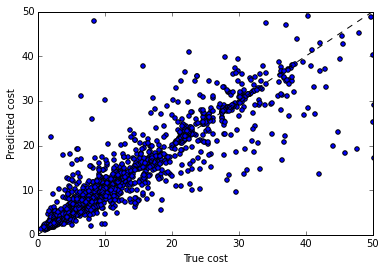

In [12]:
# Select best hyper-parameter value
min_err, n_star = sorted(zip(err_list,n_range))[0]
print(n_star)
#----------------------------------------
# train model 
model = RandomForestRegressor(n_estimators=n_star,criterion="mse")
model.fit(X_train, y_train)
#-------------------------------------
# evaluate performance on test set (generated from earlier split)
predicted = model.predict(X_test)
predicted = np.exp(predicted)-1
actual = np.exp(y_test)-1
err = rmsle(p=predicted,a=actual)
print("RMSLE: %f" %(err) )
#----------------------------------------
# visualize
import matplotlib.pylab as plt
plt.scatter(actual, predicted)
plt.xlabel('True cost')
plt.ylabel('Predicted cost')
#plt.axis('tight')
fig_list = plt.plot([0, 1000], [0, 1000], '--k')
fig = fig_list.pop()
fig.axes.set_xlim(left=0,right=50)
fig.axes.set_ylim(bottom=0,top=50)
plt.show()

In [13]:
#----------------------------------------
# predict (for submission)
features = test.drop(['id','cost'],axis=1).as_matrix()
predicted = model.predict(features)
predicted = np.exp(predicted)-1
predicted[np.where(predicted<0)] = 1 # set negative price values to 1 
                                     # because log(negative) = -infinity

In [14]:
# write as csv file
pd.set_option('mode.chained_assignment',None)
test['cost'] = predicted
submit = test[['id','cost']]
submit['id'] = submit['id'].astype(np.int) # convert from float to int
submit.to_csv("allcsv-enc-rf-split.csv",index=False)